<a href="https://colab.research.google.com/github/data2450/SVM-on-bank-dataset/blob/main/SVM_with_Bank_Marking_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
url='https://raw.githubusercontent.com/h2oai/h2o-2/master/smalldata/bank-additional-full.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [ ]:
bank_data=pd.read_csv(url,sep=';')

In [ ]:
print(bank_data.info())
bank_data.head()
#there are no null values but the dataset is a mixture of catgorical and numerical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# EDA

## numeric features

In [ ]:
#lets look at the numerical features
features_n=[features for features in bank_data.columns if bank_data[features].dtypes!='object']


In [ ]:
features_n

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

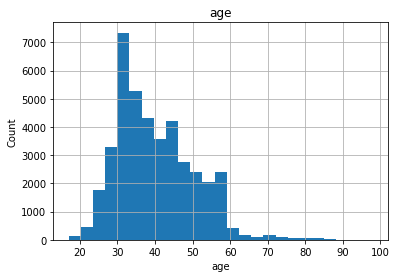

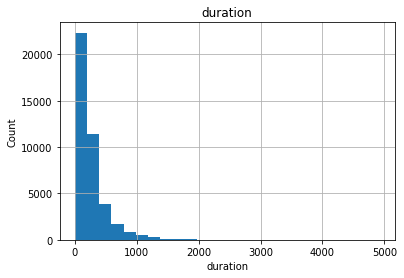

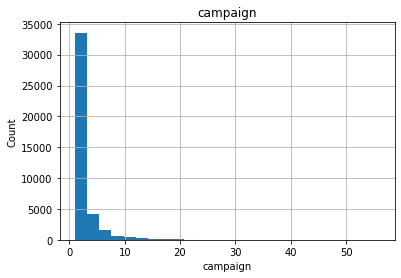

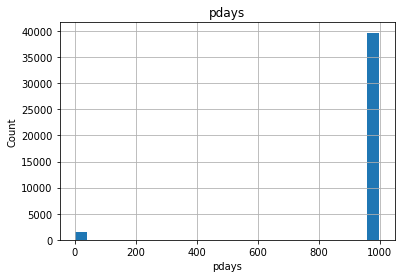

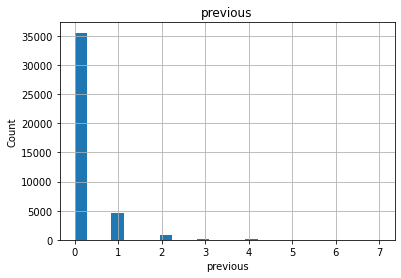

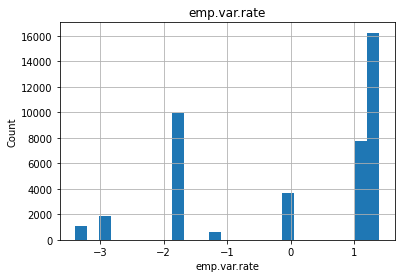

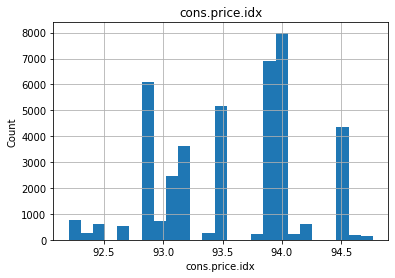

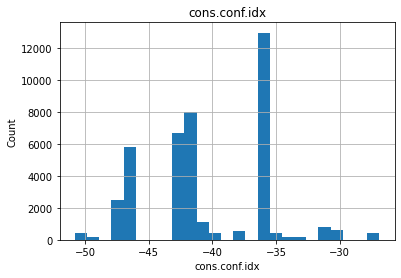

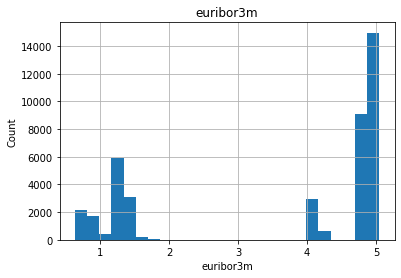

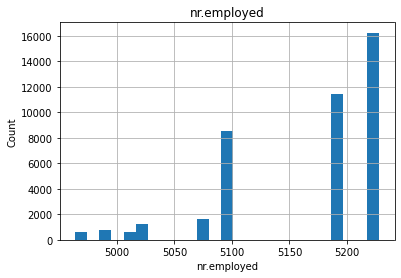

In [ ]:
for feature in features_n:
    data=bank_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

You will want to inspect if there are outliers/typos in the data. For example, if someone has an age of 200, you probably will want to remove it. Here everything seems reasonable. The pdays=999 looks like an outlier, but it actually means "client was not previously contacted", and should be included.
Before we train our SVM model, we will have to standardize the numeric data. But not right now. Let's move on to the categorical variables.



## catgorical feature
Categorical variables are more tricky. It depends on whether the variable is ordinal or nominal. An ordinal variable is something like ["extremely agree", "agree", "neutral", "disagree", "extremely disagree"]. That is, there exists a sense of ordering in the variable. A nominal variable does not have ordering in it, e.g. ["blue", "yellow", "green"]. Let's start with ordinal variables.

**Ordinal variables**
First, I personally think the variable "poutcome" (outcome of the previous marketing campaign - 'failure', 'nonexistent', 'success') is ordinal. This is based on the assumption that "success" is better than "failure", and that "nonexistent" is somewhere in between. I will therefore assign failure=-1, nonexistent=0, and success=1.

In [ ]:
features_c=[features for features in bank_data.columns if bank_data[features].dtypes=='object']
features_c

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [ ]:
bank_data['poutcome'] = bank_data['poutcome'].map({'failure': -1,'nonexistent': 0,'success': 1})


Further, I think "default" (has credit in default - 'no', 'yes', 'unknown') can be an ordinal variable, if we assume 'yes' is worse than 'no', and 'unknown' is somewhere in between. And I can assume the same for variables "housing" (has housing loan - 'no', 'yes', 'unknown') and "loan" (has personal loan -'no', 'yes', 'unknown').

In [ ]:
bank_data['default'] = bank_data['default'].map({'yes': -1,'unknown': 0,'no': 1})
bank_data['housing'] = bank_data['housing'].map({'yes': -1,'unknown': 0,'no': 1})
bank_data['loan'] = bank_data['loan'].map({'yes': -1,'unknown': 0,'no': 1})

The variable "education" ( 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown') seems to be ordered, but I choose to define it as nominal, because I am not sure what the definition of "professional.course" is and how that compares to other categories such as "high.school" and "university.degree".

**Nominal variables**
All other categorical variables except "poutcome", "default", "housing" and "loan" are considered nominal. We will use one-hot encoding on these variables. For example, we have marital = ['divorced', 'married', 'single', 'unknown']. The one-hot representation for each of the categories will be:

divorced=[1,0,0,0] 
married=[0,1,0,0] 
single=[0,0,1,0] 
unknown=[0,0,0,1] 
In python, pandas has a function get_dummies to do exactly this.

In [ ]:
nominal = ['job','marital','education','contact','month','day_of_week']
dataProcessed = pd.get_dummies(bank_data,columns=nominal)

In [ ]:
#Finally, we need to map y from yes/no to 1/0.
dataProcessed['y']=dataProcessed['y'].map({'yes': 1,'no': 0})
dataProcessed.head()

,age,default,housing,loan,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,1,1,1,261,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,57,0,1,1,149,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,37,1,-1,1,226,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,40,1,1,1,151,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,56,1,1,-1,307,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


# Train test split
Next, we will split the processed dataset into a training set and a test set. **The training set will be where we conduct cross validation (CV) for model selection, whereas the test set is unaccessbible during model selection and serves as a final step to evaluate model performance.**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# raw data
X = dataProcessed.drop('y', axis=1).values
y = dataProcessed['y'].values
# split, random_state is used for repeatable results, you should remove it if you are running your own code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


print('X train size: ', X_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', X_test.shape)
print('y test size: ', y_test.shape)

X train size:  (28831, 55)
y train size:  (28831,)
X test size:  (12357, 55)
y test size:  (12357,)


In [ ]:
#Before the training starts, standardize the numeric variables in the training set:

In [ ]:
# column index of numeric variables
idx_numeric=[0,4,5,6,8,9,10,11,12]
##print(dataProcessed.columns[idx])

# standardize numeric variables only
scaler = StandardScaler()
X_train[:,idx_numeric]=scaler.fit_transform(X_train[:,idx_numeric])
X_test[:,idx_numeric]=scaler.transform(X_test[:,idx_numeric])

Note that since we are doing cross-validation, the  Xtrain  and  ytrain  will be further split into subparts, and SVM is trained only on a subpart of (X_train, y_train). You can choose to standardize the subpart where the training actually takes place, but this means with a k-fold cross-validation, you will have to standardize k times. The fact that we only want to standardize the numeric variables further complicates the processing pipeline, but if you are really interested in doing it, you should look up sklearn functions like Pipeline, makepipeline, FeatureUnion, etc.
For now, I choose to simply normalize the whole $(X{train}, y_{train})$ dataset.

We will use Scikit-Learn's **GridSearchCV** function to conduct model selection. **This function iterates through all possible combinations of hyperparameters (e.g. kernel, gamma, C) and runs cross-validation on each combination (i.e. model). The the best model is the one that produces the highest score during cross validation. Note that during cross-validation GridSearchCV will split  (Xtrain,ytrain)  further into train and test set. Once the best model is found, GridSearchCV train the best model on the whole train data  (Xtrain,ytrain) , and it is this trained best model that will be used for further prediction.**
The score of interest is chosen by the user and some of the popular scores are: accuracy, recall, and precision. Here we will use precision.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.1],
                     'C': [1]},
                    {'kernel': ['linear'], 'C': [1]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='precision')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1], 'gamma': [0.1], 'kernel': ['rbf']},
                         {'C': [1], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=0)

This training will take some time. After it finishes, we can print out the detailed cross validation results:



In [ ]:
print(clf.cv_results_)

{'mean_fit_time': array([18.46234159, 11.21893573]), 'std_fit_time': array([0.236086  , 2.10780467]), 'mean_score_time': array([3.27818098, 1.08389845]), 'std_score_time': array([0.07725805, 0.01748457]), 'param_C': masked_array(data=[1, 1],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.1, --],
             mask=[False,  True],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['rbf', 'linear'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1, 'kernel': 'linear'}], 'split0_test_score': array([0.62878788, 0.64114833]), 'split1_test_score': array([0.6631016 , 0.65291262]), 'split2_test_score': array([0.65174129, 0.64319249]), 'split3_test_score': array([0.69946809, 0.68347339]), 'split4_test_score': array([0.67525773, 0.67      ]), 'mean_test_score': array([0.66367132, 0.65814536]), 'std

Since we set cv=5, GridSearchCV conducted a 5-fold cross-validation. For each fold there is a "test score", which in our case is the precision of prediction on the hold-out set for that fold. You can find these test scores in **'split0_test_score', 'split1_test_score',...,'split4_test_score'**. There are two values in each score vector, because we tested two models: {kernel=rbf, gamma=0.1, C=1} and {kernel=linear, C=1}. The average of the five test scores is recorded in **'mean_test_score'**, and standard deviation in '**std_test_score**'. The '**mean_test_score**' is used to select the best model. Let's see in our case which model works better:

In [ ]:
print('The best model is: ', clf.best_params_)
print('This model produces a mean cross-validated score (precision) of', clf.best_score_)

The best model is:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
This model produces a mean cross-validated score (precision) of 0.6636713187326876


For this tutorial I only selected between two models: {kernel=rbf, gamma=0.1, C=1} and {kernel=linear, C=1} since the training is taking quite long. If you wanna test more models, you can do something like:

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.1, 1], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

GridSearchCV will then test all possible combinations of hyperparamters given in tuned_parameters. Be aware, though, that the function may take a very long time to finish.

# final performance
Now that we have the best model, let's see how it performs on the evaluation set  (Xtest,ytest) 

In [ ]:
from sklearn.metrics import precision_score, accuracy_score

In [ ]:
y_true, y_pred = y_test, clf.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

precision on the evaluation set:  0.6639150943396226
accuracy on the evaluation set:  0.910091446143886


The prediction accuracy on the evaluation set is 90.0%, which is pretty good given that we did not select models based on accuracy. The prediction precision is 64.8%, which means among all clients that are predicited to subscribe a term deposit, 64.8% will acutally do so . This precision score is very close to the model's mean cross-validated precision score on  (Xtrain,ytrain) , which is a good sign that the model is not overfitting.
There are definitely space to improve prediction precision. Some ideas include:

Include more models into GridSearchCV (e.g. different gamma and C values for SVC, or even classifiers other than SVM)
Change data processing pipeline (e.g. treat variables as nominal instead of ordinal, standardardization on each CV fold)
Change train-test ratio